In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

sys.path.insert(0,'/home/akiva/FCNX-Ensembling/lib/')
from FCN3Network import FCN3NetworkActivationGeneric

# --- Parameters ---
d = 2
n1 = 400
n2 = 400
P = 10
chi = 1.0 # standard scaling
kappa = 1.0
T = 2.0 * kappa / chi
num_epochs = 100_000
lr = 1e-7
ens = 100

# --- Data ---
torch.manual_seed(42)
X = torch.randn(P, d, device="cuda:1")  # shape: (P, d)
y = X[:, 0].unsqueeze(1)  # shape: (P, 1)

# --- Model ---
model = FCN3NetworkActivationGeneric(
    d=d, n1=n1, n2=n2, P=P, ens=ens, activation="linear",
    weight_initialization_variance=(1/d, 1/n1, 1/(n2*chi)), device="cuda:1"
)


# --- Langevin training with explicit weight decay (as in fcn3_train_mean_field.py) ---
def langevin_train(model, X, y, lr, T, n_epochs, chi=1.0):
    losses = []
    # Print initial loss
    with torch.no_grad():
        y_pred = model(X)
        initial_loss = ((y_pred - y) ** 2).sum().item()
        print(f"Initial loss: {initial_loss:.6f}")
        losses.append(initial_loss)
    dt = lr

    for epoch in range(n_epochs):
        model.zero_grad()
        y_pred = model(X)  
        # Use sum reduction for all ensemble members
        loss = ((y_pred - y) ** 2).sum()
        loss.backward()

        torch.manual_seed(epoch + 12345)  # For reproducibility
        with torch.no_grad():
            for name, param in model.named_parameters():

                if param.grad is not None:
                    # Weight decay: 1/fan-in for each layer (match fcn3_train_mean_field.py)
                    if name.endswith('A'):
                        decay = param.data * T * (1/model.sigma2A)
                    elif name.endswith('W1'):
                        decay = param.data * T * (1/model.sigma2W1)
                    elif name.endswith('W0'):
                        decay = param.data * T * (1/model.sigma2W0)
                    noise = torch.randn_like(param) * (2 * T * dt) ** 0.5
                    param.add_(-dt * (param.grad + decay) + noise)
                else:
                    print("You fucking moron, param.grad is None!")
        if epoch % 1000 == 0:
            losses.append(loss.item())
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return losses


Initial loss: 1830.568848
Epoch 0 loss: 1830.568848
Epoch 1000 loss: 471.570984
Epoch 2000 loss: 280.071777
Epoch 3000 loss: 190.581039
Epoch 4000 loss: 190.546524
Epoch 5000 loss: 213.805130
Epoch 6000 loss: 193.729233
Epoch 7000 loss: 206.341370
Epoch 8000 loss: 187.007324
Epoch 9000 loss: 216.034424
Epoch 10000 loss: 199.355835
Epoch 11000 loss: 183.274216
Epoch 12000 loss: 202.744949
Epoch 13000 loss: 237.290131
Epoch 14000 loss: 193.528244
Epoch 15000 loss: 181.666443
Epoch 16000 loss: 162.891083
Epoch 17000 loss: 189.632721
Epoch 18000 loss: 191.516983
Epoch 19000 loss: 196.854889
Epoch 20000 loss: 179.789734
Epoch 21000 loss: 216.852142
Epoch 22000 loss: 186.051178
Epoch 23000 loss: 169.552658
Epoch 24000 loss: 210.090103
Epoch 25000 loss: 188.781006
Epoch 26000 loss: 187.751526
Epoch 27000 loss: 186.581512
Epoch 28000 loss: 206.100052
Epoch 29000 loss: 183.655502
Epoch 30000 loss: 165.441833
Epoch 31000 loss: 218.131866
Epoch 32000 loss: 198.063553
Epoch 33000 loss: 204.751251


In [ ]:
# --- Train ---
losses = langevin_train(model, X, y, lr, T, num_epochs)



K = arcsin_kernel(X)

# --- Plot GPR kernel output ---
plt.figure(figsize=(7,5))
plt.imshow(K.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Kernel value')
plt.title(f'GPR Arcsin Kernel (kappa={kappa}, T={T})')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.tight_layout()
plt.savefig('gpr_arcsin_kernel_output.png', dpi=150)
plt.close()
print('Saved GPR arcsin kernel plot to gpr_arcsin_kernel_output.png')

In [5]:
def linear_dot_kernel(X: torch.Tensor) -> torch.Tensor:
    """Compute normalized dot product kernel matrix: K(x, x') = (x·x') / d."""
    K = torch.einsum('ui,vi->uv', X, X) / X.shape[1]
    return K

In [61]:

K = linear_dot_kernel(X)

# --- Plot GPR kernel output ---
plt.figure(figsize=(7,5))
plt.imshow(K.cpu().numpy(), aspect='auto', cmap='viridis')
plt.colorbar(label='Kernel value')
plt.title(f'GPR Arcsin Kernel (kappa={kappa}, T={T})')
plt.xlabel('Sample')
plt.ylabel('Sample')
plt.tight_layout()
plt.savefig('gpr_arcsin_kernel_output.png', dpi=150)
plt.close()
print('Saved GPR arcsin kernel plot to gpr_arcsin_kernel_output.png')

Saved GPR arcsin kernel plot to gpr_arcsin_kernel_output.png


In [62]:
def gpr(K: torch.Tensor, Y: torch.Tensor, sigma0_sq: float) -> torch.Tensor:
    """Simple GPR prediction with arcsin kernel on training data."""
    n = K.shape[0]
    K_reg = K + sigma0_sq * torch.eye(n, device=X.device)
    alpha = torch.linalg.solve(K_reg, Y)
    return K @ alpha
f_gpr = gpr(K, y, sigma0_sq=kappa).squeeze().detach().cpu().numpy()
f_nngp = model(X).mean(axis=1).detach().cpu().numpy()
f_gpr.shape, f_nngp.shape

((10,), (10,))

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


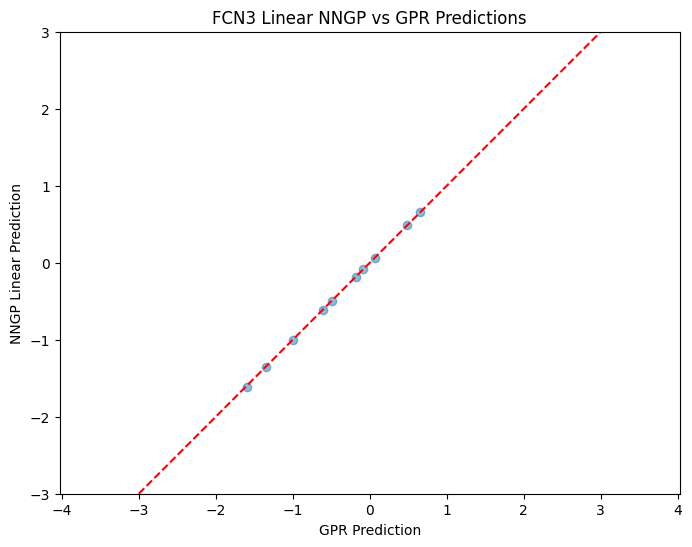

In [64]:
plt.figure(figsize=(8,6))
plt.scatter(f_gpr, f_nngp, alpha=0.5)
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("GPR Prediction")
plt.ylabel("NNGP Linear Prediction")
plt.title("FCN3 Linear NNGP vs GPR Predictions")

plt.axis('equal')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()


## Erf

In [11]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
num_epochs = 200_000
sys.path.insert(0,'/home/akiva/FCNX-Ensembling/lib/')
from FCN3Network import FCN3NetworkActivationGeneric
d = 20
# Integers from 20 to 5000 logarithmically spaced
# --- Compute GPR arcsin kernel ---
def arcsin_kernel(X):
    XXT = torch.einsum('ui,vi->uv', X, X) / X.shape[1]
    diag = torch.sqrt((1 + 2 * XXT).diag())
    denom = diag[:, None] * diag[None, :]
    arg = 2 * XXT / denom

    return (2 / torch.pi) * torch.arcsin(arg)
def linear_dot_kernel(X: torch.Tensor) -> torch.Tensor:
    """Compute normalized dot product kernel matrix: K(x, x') = (x·x') / d."""
    K = torch.einsum('ui,vi->uv', X, X) / X.shape[1]
    return K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
d, n1, n2, P, ens, chi = 2, 400, 400, 10, 10, 1.0
k = 1.0 
T = 2 * k
lr = 1e-6
num_epochs = 500_000


torch.manual_seed(42)
X = torch.randn(P, d, device="cuda:1")
y = X[:, 0].unsqueeze(1)
model_erf = FCN3NetworkActivationGeneric(
    d=d, n1=n1, n2=n2, P=P, ens=ens, activation="erf",
    weight_initialization_variance=(1/d, 1/n1, 1/(n2*chi)), device="cuda:1"
)
losses = model_erf.langevin_train(X, y, lr, T, num_epochs, chi = chi)


Initial loss: 128.084534
Epoch 0 loss: 12.808453
Epoch 1000 loss: 8.299305
Epoch 2000 loss: 11.246267
Epoch 3000 loss: 7.428321
Epoch 4000 loss: 8.669352
Epoch 5000 loss: 8.889454
Epoch 6000 loss: 11.176522
Epoch 7000 loss: 8.880567
Epoch 8000 loss: 7.467900
Epoch 9000 loss: 8.743335
Epoch 10000 loss: 10.748740
Epoch 11000 loss: 10.694668
Epoch 12000 loss: 9.132830
Epoch 13000 loss: 8.014719
Epoch 14000 loss: 11.778275
Epoch 15000 loss: 7.550121
Epoch 16000 loss: 8.484917
Epoch 17000 loss: 8.885303
Epoch 18000 loss: 12.416802
Epoch 19000 loss: 8.491801
Epoch 20000 loss: 9.633448
Epoch 21000 loss: 10.314447
Epoch 22000 loss: 13.458187
Epoch 23000 loss: 9.945680
Epoch 24000 loss: 9.722895
Epoch 25000 loss: 13.045016
Epoch 26000 loss: 8.820290
Epoch 27000 loss: 14.365393
Epoch 28000 loss: 8.958639
Epoch 29000 loss: 12.376459
Epoch 30000 loss: 10.869447
Epoch 31000 loss: 8.180952
Epoch 32000 loss: 11.430428
Epoch 33000 loss: 10.309776
Epoch 34000 loss: 10.499770
Epoch 35000 loss: 10.524418

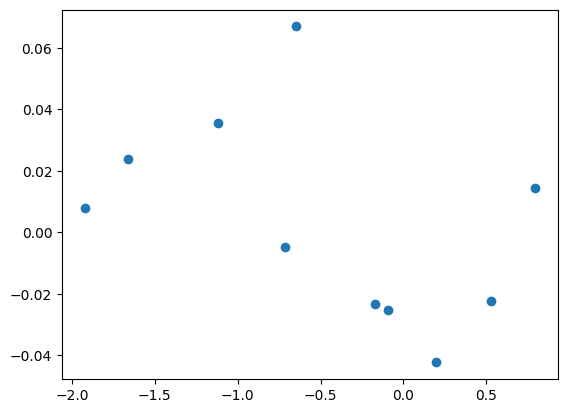

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


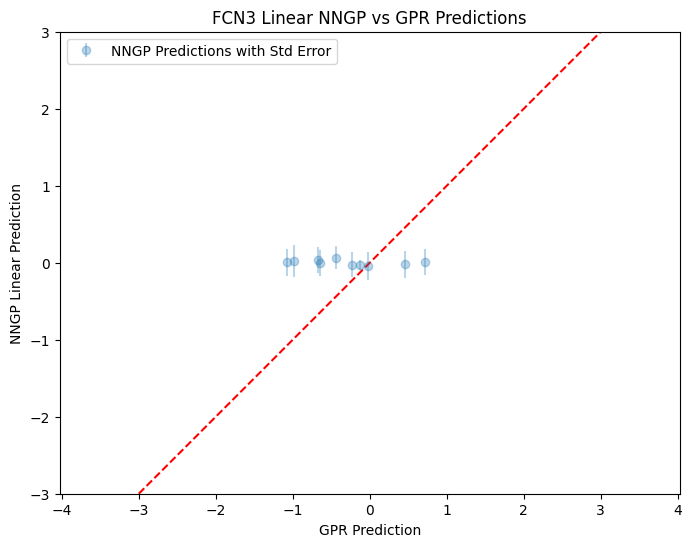

In [13]:
def gpr(K: torch.Tensor, Y: torch.Tensor, sigma0_sq: float) -> torch.Tensor:
    """Simple GPR prediction with arcsin kernel on training data."""
    n = K.shape[0]
    K_reg = K + sigma0_sq * torch.eye(n, device=X.device)
    alpha = torch.linalg.solve(K_reg, Y)
    return K @ alpha

K = arcsin_kernel(X)
plt.plot(X[:,0].cpu().numpy(), model_erf(X).mean(axis=1).detach().cpu().numpy(), 'o')

f_gpr = gpr(K, y, sigma0_sq=k).squeeze().detach().cpu().numpy()
f_nngp = model_erf(X).mean(axis=1).detach().cpu().numpy()
f_nngp_err = model_erf(X).std(axis=1).detach().cpu().numpy() / np.sqrt(ens)
plt.figure(figsize=(8,6))
# plt.scatter(f_gpr, f_nngp, alpha=0.5)
plt.errorbar(f_gpr, f_nngp, yerr=f_nngp_err, fmt='o', alpha=0.3, label='NNGP Predictions with Std Error')
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("GPR Prediction")
plt.ylabel("NNGP Linear Prediction")
plt.title("FCN3 Linear NNGP vs GPR Predictions")

plt.axis('equal')
plt.legend()
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()


In [ ]:
d, n1, n2, P, ens, chi = 2, 400, 400, 10, 10, 1.0
k = 1.0 / P
T = 2 * k
lr = 1e-6
num_epochs = 1_000_000

# --- Model ---
seeds, models, losses = [],  [], []
for i in range(1):
    torch.manual_seed(42 + i)
    X = torch.randn(P, d, device="cuda:1")
    y = X[:, 0].unsqueeze(1)
    model_erf = FCN3NetworkActivationGeneric(
     d=d, n1=n1, n2=n2, P=P, ens=ens, activation="erf",
     weight_initialization_variance=(1/d, 1/n1, 1/(n2*chi)), device="cuda:1"
    )
    models.append(model_erf)
    losses.append(model_erf.langevin_train(X, y, lr, T, num_epochs, chi = chi))
    seeds.append(42 + i)

Initial loss: 128.084534
Epoch 0 loss: 1.280845
Epoch 1000 loss: 1.073594
Epoch 2000 loss: 1.042763
Epoch 3000 loss: 0.932478
Epoch 4000 loss: 1.129244
Epoch 5000 loss: 0.927646
Epoch 6000 loss: 1.000633
Epoch 7000 loss: 0.987415
Epoch 8000 loss: 1.021757
Epoch 9000 loss: 0.942888
Epoch 10000 loss: 1.020187
Epoch 11000 loss: 0.830065
Epoch 12000 loss: 1.001547
Epoch 13000 loss: 0.926996
Epoch 14000 loss: 1.014485
Epoch 15000 loss: 1.111200
Epoch 16000 loss: 1.149851
Epoch 17000 loss: 1.160551
Epoch 18000 loss: 1.016363
Epoch 19000 loss: 0.938998
Epoch 20000 loss: 0.903975
Epoch 21000 loss: 0.947961
Epoch 22000 loss: 1.076072
Epoch 23000 loss: 0.915123
Epoch 24000 loss: 0.925998
Epoch 25000 loss: 0.919042
Epoch 26000 loss: 0.896736
Epoch 27000 loss: 1.134443
Epoch 28000 loss: 1.033989
Epoch 29000 loss: 1.072559
Epoch 30000 loss: 1.053514
Epoch 31000 loss: 1.085762
Epoch 32000 loss: 1.113452
Epoch 33000 loss: 1.255705
Epoch 34000 loss: 1.262289
Epoch 35000 loss: 1.040418
Epoch 36000 loss

1

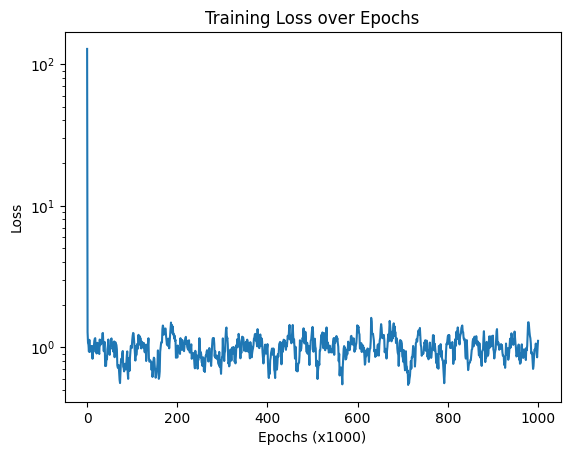

In [22]:
plt.figure()
for loss in losses:
    plt.plot(loss)
plt.yscale('log')
plt.xlabel('Epochs (x1000)')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

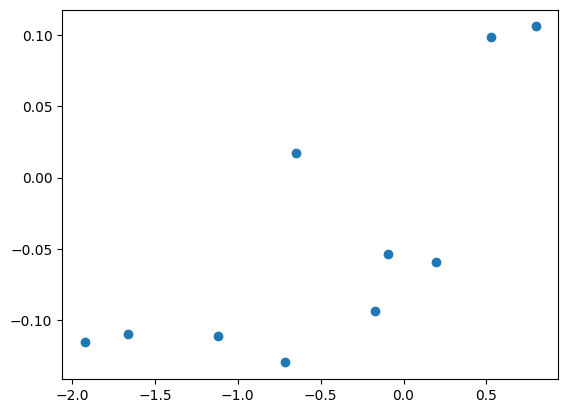

In [39]:
torch.manual_seed(42)
X = torch.randn(P, d, device="cuda:1")
y = X[:, 0].unsqueeze(1)
plt.scatter(X[:,0].detach().cpu().numpy(), models[0](X).mean(axis=1).detach().cpu().numpy())

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


[0.17536637 0.1671774  0.18727632 0.2182475  0.18209458 0.25974686
 0.07255928 0.19522283 0.1647218  0.1883613 ]


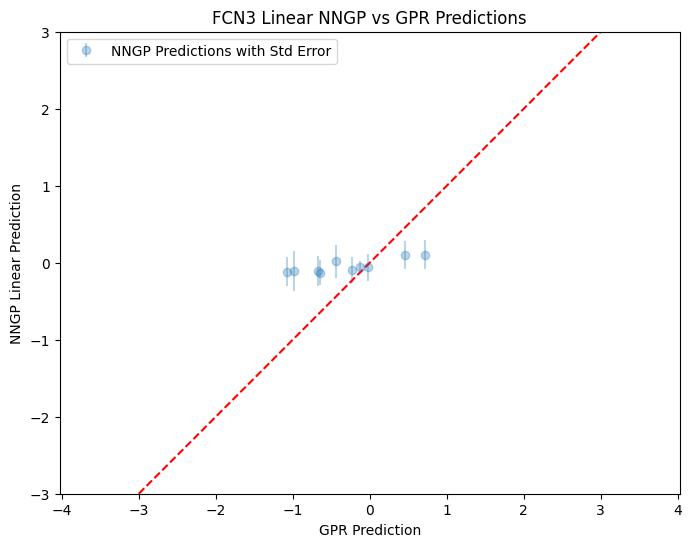

In [33]:
datas = []
gprs = []
for i in range(len(models)):
    torch.manual_seed(42 + i)
    X = torch.randn(P, d, device="cuda:1")
    datas.append(X)
    K = arcsin_kernel(X)
    gprs.append(gpr(K, y, sigma0_sq=1.0).squeeze().detach().cpu().numpy())


f_gpr = np.array(gprs).mean(axis=0)
f_nngp = np.array([model(datas[i]).mean(axis=1).detach().cpu().numpy() for i, model in enumerate(models)]).mean(axis=0)
f_nngp_err = np.array([model(datas[i]).std(axis=1).detach().cpu().numpy() for i, model in enumerate(models)]).mean(axis=0) / np.sqrt(ens) / np.sqrt(len(models))
print(f_nngp_err)

plt.figure(figsize=(8,6))
# plt.scatter(f_gpr, f_nngp, alpha=0.5)
plt.errorbar(f_gpr, f_nngp, yerr=f_nngp_err, fmt='o', alpha=0.3, label='NNGP Predictions with Std Error')
plt.plot([-3, 3], [-3, 3], 'r--')
plt.xlabel("GPR Prediction")
plt.ylabel("NNGP Linear Prediction")
plt.title("FCN3 Linear NNGP vs GPR Predictions")

plt.axis('equal')
plt.legend()
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.show()


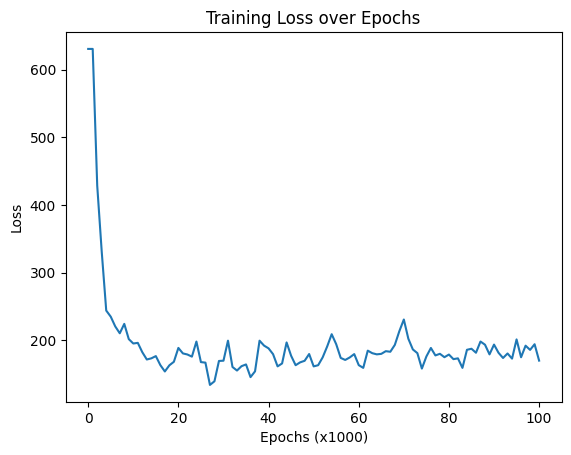

plt.plot(losses)